In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvx_portfolio as cp

plotdir = '../portfolio/plots/'

sigmas=pd.read_csv('sigmas.csv.gz',index_col=0,parse_dates=[0])
returns=pd.read_csv('returns.csv.gz',index_col=0,parse_dates=[0])
volumes=pd.read_csv('volumes.csv.gz',index_col=0,parse_dates=[0])
a = pd.read_csv('a.csv.gz',index_col=0,parse_dates=[0])
b = pd.read_csv('b.csv.gz',index_col=0,parse_dates=[0])
s = pd.read_csv('s.csv.gz',index_col=0,parse_dates=[0])

w_b = pd.Series(index=returns.columns, data=1)
w_b.USDOLLAR = 0.
w_b/=sum(w_b)

start_t="2012-01-01"
end_t="2016-12-31"

simulated_tcost = cp.TcostModel(volumes, sigmas, a, b, cash_key='USDOLLAR')
simulated_hcost = cp.HcostModel(s, cash_key='USDOLLAR')
simulator = cp.MarketSimulator(returns, volumes, [simulated_tcost, simulated_hcost], cash_key='USDOLLAR')

return_estimate=pd.read_csv('return_estimate.csv.gz',index_col=0,parse_dates=[0])
volume_estimate=pd.read_csv('volume_estimate.csv.gz',index_col=0,parse_dates=[0])
sigma_estimate=pd.read_csv('sigma_estimate.csv.gz',index_col=0,parse_dates=[0])

alpha_model = cp.AlphaSource(return_estimate)
optimization_tcost=cp.TcostModel(volume_estimate, sigma_estimate, a, b, cash_key='USDOLLAR')
optimization_hcost=cp.HcostModel(s, cash_key='USDOLLAR')

risk_data = pd.HDFStore('risk_model.h5')
risk_model = cp.FactorModelSigma(risk_data.exposures, risk_data.factor_sigma, risk_data.idyos)

results={}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulations

In [21]:
policies={}
gamma_risks=[ 30., 100.,300., 1000.]#[ 30., 60, 100., 110., 300., 600., 1000., 1100.]
gamma_tcosts=[30., 100., 300., 1000.]
for gamma_risk in gamma_risks:
    for gamma_tcost in gamma_tcosts : 
        policies[(gamma_risk, gamma_tcost)] = \
      cp.SinglePeriodOpt(alpha_model, [gamma_risk*risk_model,gamma_tcost*optimization_tcost,optimization_hcost], 
                                [cp.LeverageLimit(3)])

import warnings
warnings.filterwarnings('ignore')
results.update(dict(zip(policies.keys(), simulator.run_multiple_backtest(1E8*w_b, start_time=start_t,end_time=end_t,
                                              policies=policies.values(), parallel=True))))

In [22]:
result_df=pd.DataFrame()
for k in results:
    result_df.loc[k[0], k[1]] = results[k]
result_df.index.name = 'gamma_risk'
result_df.columns.name = 'gamma_tcost'
result_df = result_df.reindex(index=sorted(result_df.index),columns=sorted(result_df.columns))

benchmark_returns = returns.loc[(returns.index>=start_t)&(returns.index<=end_t)].USDOLLAR

result_df_used= result_df#[[100.,300.,1000.]]

table=pd.DataFrame()
table[r'Excess return']=\
result_df_used.applymap(lambda res: 100*250*(res.returns - benchmark_returns).mean()).unstack()
table[r'Excess risk']= \
    result_df_used.applymap(lambda res: np.std(benchmark_returns - res.returns)*100*np.sqrt(250)).unstack()
table[r'Transaction costs']=\
    result_df_used.applymap(lambda res: (res.simulator_TcostModel.sum(1)/res.v).mean() * 100 * 250).unstack()  

table['SR']=\
    result_df_used.applymap(lambda res: res.sharpe_ratio).unstack()  


table
#table_print=pd.DataFrame(table,copy=True)
#table_print=table_print.set_index(table_print.index.set_levels([["%g"%i for i in table_print.index.levels[0]],
#                      ["%g"%i for i in table_print.index.levels[1]]]))
#table_print.ix[:,:]=table_print.ix[:,:].applymap(lambda x: r'%.2f%%'%x )
#print(table_print.to_latex(float_format='%.2f', escape=False).replace('%',r'\%'))

Excess return  Excess risk  Transaction costs  \
gamma_tcost gamma_risk                                                  
30.0        30.0            20.676990    65.812870         450.945216   
            100.0           11.927496    53.147167         405.393218   
            300.0            4.501377    40.689862         341.112899   
            1000.0          -0.158341    29.092315         264.289170   
100.0       30.0            39.830825    17.166926          62.103479   
            100.0           37.723782    14.749113          62.377782   
            300.0           35.197717    12.293014          60.320812   
            1000.0          29.448460     8.768407          55.748258   
300.0       30.0            17.283943    11.118921           2.611971   
            100.0           15.014136     8.917890           2.803053   
            300.0           12.664463     6.104389           2.929020   
            1000.0          10.314920     3.889217           2.935777   
1000.0      30.0            15.805959    13.491544           0.001239   
            100.0           15.188152    12.874009           0.001724   
            300.0           11.711882     9.372995           0.005088   
            1000.0           5.950460     4.675861           0.010451   

                              SR  
gamma_tcost gamma_risk            
30.0        30.0        0.315433  
            100.0       0.225320  
            300.0       0.111068  
            1000.0     -0.005464  
100.0       30.0        2.329470  
            100.0       2.567909  
            300.0       2.874659  
            1000.0      3.371880  
300.0       30.0        1.560668  
            100.0       1.690318  
            300.0       2.082931  
            1000.0      2.662772  
1000.0      30.0        1.176222  
            100.0       1.184463  
            300.0       1.254523  
            1000.0      1.277672

### DOnt plot gamma trade = 30, get rid of turnover 

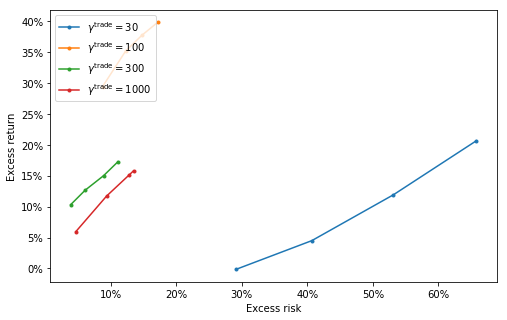

In [23]:
plt.figure(figsize=(8,5))
for gamma_tcost in table.index.levels[0][:]:
    x = table.loc[gamma_tcost]['Excess risk']
    y = table.loc[gamma_tcost]['Excess return']
    plt.plot(np.array(x),np.array(y), '.-', label='$\gamma^\mathrm{trade} = %g$'%gamma_tcost)
plt.legend(loc='upper left')
plt.xlabel('Excess risk')
plt.ylabel('Excess return')
#plt.xlim([4,23])
#plt.ylim([0,30])


import matplotlib.ticker as mtick
ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.0f%%'))

plt.savefig(plotdir+'spo_riskrewardfrontier.png')

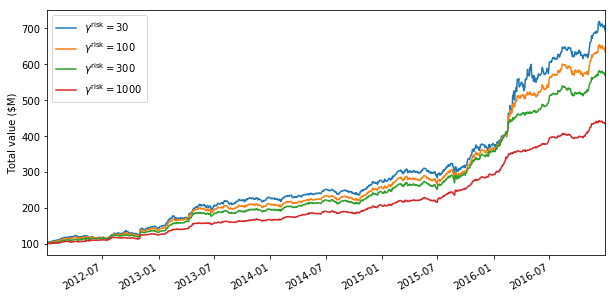

In [24]:
gamma_tcost=100#gamma_tcosts[2]
plt.figure(figsize=(10,5))

[(results[(i, gamma_tcost)].v/1E6).plot(label='$\gamma^\mathrm{risk} = %g$'%i) for i in gamma_risks]
plt.legend(loc='upper left')# if i==0 else 'upper left')
plt.ylabel('Total value (\$M)')
plt.savefig(plotdir+'spo_valueintime.png')

In [15]:
result_df.applymap(lambda x: x.sharpe_ratio)

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.279506,1.263188,1.026669,0.516143
100.0,0.153190,1.313718,1.059932,0.473930
300.0,-0.005531,1.715168,0.930027,0.611939
1000.0,-0.183357,2.589567,1.268232,0.819903


In [16]:
result_df.applymap(lambda x: x.policy_time.mean() + x.simulation_time.mean())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,0.631352,0.824512,0.879987,0.671997
100.0,0.705715,0.806136,0.878431,0.772043
300.0,0.731359,0.724765,0.872514,0.772960
1000.0,0.761064,0.813199,0.874184,0.811322


In [17]:
result_df.applymap(lambda x: x.policy_time.sum() + x.simulation_time.sum())

gamma_tcost,30.0,100.0,300.0,1000.0
gamma_risk,,,,
30.0,794.240667,1037.236284,1107.023405,845.372384
100.0,887.789501,1014.118917,1105.065884,971.230425
300.0,920.049039,911.754739,1097.623225,972.383445
1000.0,957.418989,1023.004778,1099.724065,1020.643411


## Other diagnostics

([30.0, 100.0, 300.0, 1000.0], 1000.0)

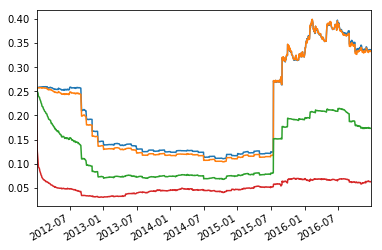

In [20]:
gamma_tcost=gamma_tcosts[-1]
[(np.sqrt(250)*np.sqrt(results[(i, gamma_tcost)].policy_FactorModelSigma)).plot() for i in gamma_risks]
gamma_risks, gamma_tcost

([30.0, 100.0, 300.0, 1000.0], 300.0)

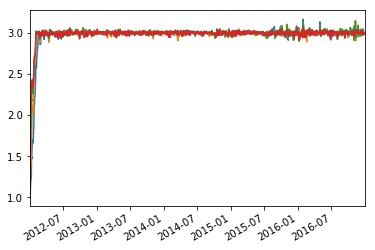

In [21]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 100.0)

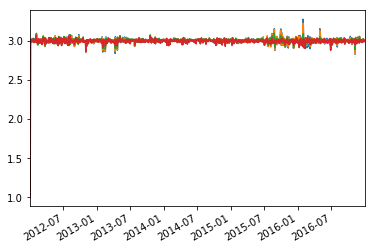

In [22]:
[results[(i, gamma_tcosts[1])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[1]

([30.0, 100.0, 300.0, 1000.0], 300.0)

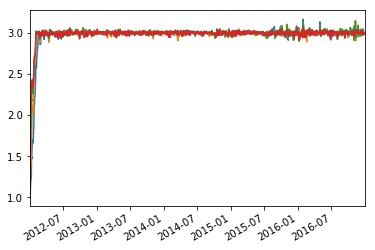

In [23]:
[results[(i, gamma_tcosts[2])].leverage.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 300.0)

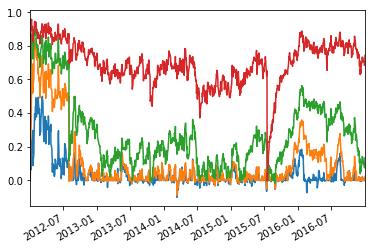

In [24]:
[results[(i, gamma_tcosts[2])].w.USDOLLAR.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

([30.0, 100.0, 300.0, 1000.0], 300.0)

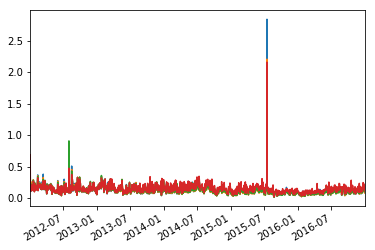

In [25]:
[results[(i, gamma_tcosts[2])].turnover.plot() for i in gamma_risks]
gamma_risks, gamma_tcosts[2]

In [26]:
# res.turnover.plot()
# res.policy_TcostModel.sum(1).plot(secondary_y=True)

NameError: name 'res' is not defined

In [ ]:
# res.policy_TcostModel.sum(1).plot()
# res.simulator_TcostModel.sum(1).plot(secondary_y=True)

In [ ]:
# (res.policy_TcostModel.sum(1)).tail(100).plot(style='.-')
# (res.simulator_TcostModel.sum(1)/res.v).tail(100).plot(style='.-')